# Import & load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
def fill_in_rate(df, x_size=10, y_size=3):
    """Plot fill in rate of each column of the data set selected"""
    fill = df.notna().mean()  # donne le % de valeur not NA par colonne
    fill.sort_values(inplace=True)
    fill.plot.barh(figsize=(x_size, y_size))
    plt.ylabel("Colonnes du dataset", fontsize=14)
    plt.xlabel("Taux de remplissage", fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.title("Taux de remplissage par colonne.", fontsize=20)
    plt.show()  # ==> enlève les txt
    
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
# chargement du fichier pickle
df = pd.read_pickle(r"C:\Users\vassalr\OneDrive - STMicroelectronics\Documents\Robin\DataScience\Dataset\Projet7\home-credit-default-risk\dataset_pickled.pkl")
df.shape

(307507, 797)

# Prepare

## Stratified Sampling (ratio=0.1)

https://en.wikipedia.org/wiki/Stratified_sampling
The objective is to improve the precision of the sample by reducing sampling error. 
It can produce a weighted mean that has less variability than the arithmetic mean of a simple random sample of the population

In [4]:
application_sample1 = df.loc[df.TARGET==1].sample(frac=0.010, replace=False)
application_sample0 = df.loc[df.TARGET==0].sample(frac=0.010, replace=False)

print('label 1 sample size:', str(application_sample1.shape[0]))
print('label 0 sample size:', str(application_sample0.shape[0]))

application = pd.concat([application_sample1, application_sample0], axis=0).sort_values('SK_ID_CURR')
del df; gc.collect() # invoke the Garbage Collector to release unreferenced memory

label 1 sample size: 248
label 0 sample size: 2827


18

## Impute missing values

In [5]:
missing_values_table(application)

Your selected dataframe has 797 columns.
There are 610 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_AMT_DOWN_PAYMENT_MAX,2611,84.9
REFUSED_AMT_DOWN_PAYMENT_MEAN,2611,84.9
REFUSED_AMT_DOWN_PAYMENT_MIN,2611,84.9
REFUSED_RATE_DOWN_PAYMENT_MIN,2611,84.9
REFUSED_RATE_DOWN_PAYMENT_MAX,2611,84.9
...,...,...
DEF_60_CNT_SOCIAL_CIRCLE,6,0.2
OBS_60_CNT_SOCIAL_CIRCLE,6,0.2
DEF_30_CNT_SOCIAL_CIRCLE,6,0.2
OBS_30_CNT_SOCIAL_CIRCLE,6,0.2


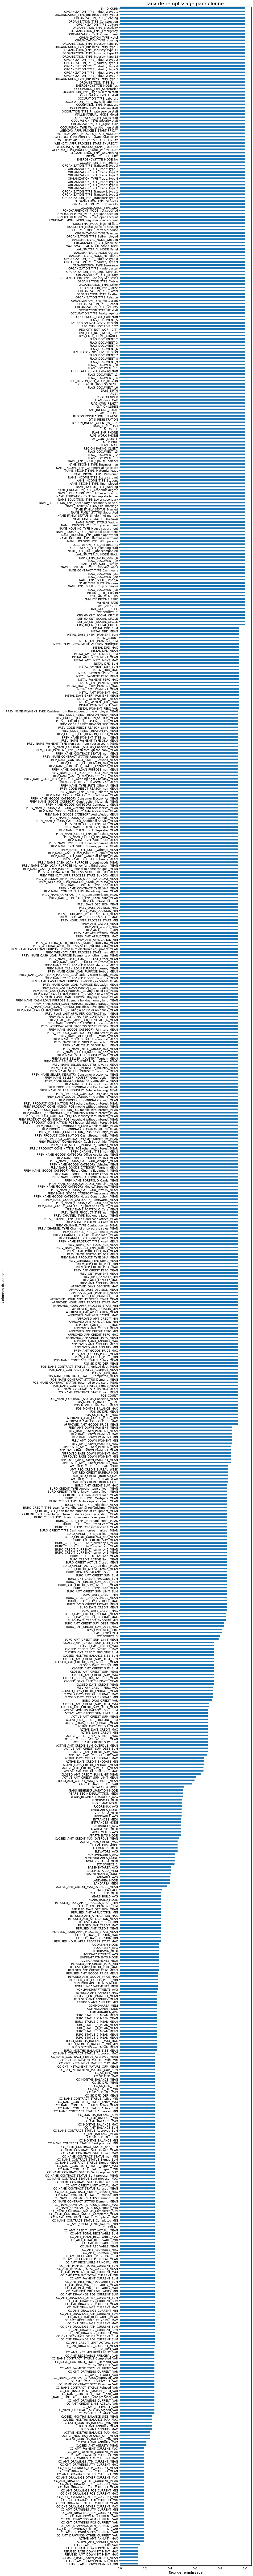

In [82]:
fill_in_rate(application, y_size=200)

In [6]:
# remove features that contains more than 50% of NaN ? On Perd EXt_1

#### Median imputation

In [7]:
from sklearn.impute import SimpleImputer
print(type(application))
application.replace([np.inf, -np.inf], np.nan, inplace=True)
print(type(application))
# median imputation 
application[:] = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(application[:])
print(type(application))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### X & y

In [8]:
X = application.drop(['SK_ID_CURR', 'TARGET'], axis=1) # remove feature specified
y = application.TARGET # keep only target
feature_name = X.columns.tolist()
print("X shape = {}".format(X.shape))
print("y shape = {}".format(y.shape))

X shape = (3075, 795)
y shape = (3075,)


0.0    2827
1.0     248
Name: TARGET, dtype: int64


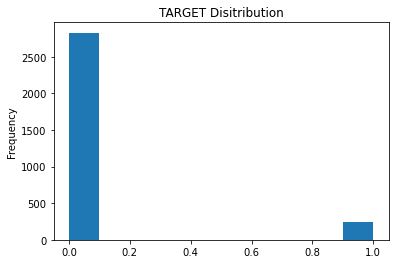

In [9]:
print(y.value_counts())
y.plot.hist(title = "TARGET Disitribution");

# Feature selection
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection

## Corrélation de Pearson

- Impute values : YES
- No Normalization

In [10]:
def cor_selector(X, y):
    """Function that calculates the Pearson's coefficient of each feature with the target,
    then retains only the 100 first most correlated to the target variable."""
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist() # give a list of the 100 first features names
    # feature selection : 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name] # keep only features cor_feature list
    
    return cor_support, cor_feature

In [11]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


## Select KBest with Chi-2 estimator
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
- **tester l'indépendance entre deux variables aléatoires.**
- Sélection de variables basée sur le test de dependance.
- **SelectKBest** sélectionne les K variables X dont le score du test de dépendance avec y est le plus élevé.
- **Classification :** chi2, ANOVA
- **Régression:** Pearson Correlation

- Impute values : YES
- Normalization MinMaxScaler

In [12]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X) # normalization [0; 1]
# chi2(X_norm, y)

Chi2 output :
- 1- Dans le premier tableau on retourne le score du test chi2 pour chaque variable. Plus il est élevé plus la dépendance est
    grande entre la variable et la target y.
- 2- Les p-values, soit les valeur-p du test.

In [13]:
chi_selector = SelectKBest(chi2, k=100) # on sélectionne les 100 premières variables avec les scores statistiques du test chi2 
# les plus elevées
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x00000216021A5940>)

In [14]:
len(X.columns[chi_selector.get_support()]) # liste des 100 features sélectionnées

100

In [15]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


## Recursive Feature Elimination (RFE)
-https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- Un estimateur est entraîné plusieurs fois, après chaque entraînement, des features sont éliminées sur la base des coefficients les plus faibles de l'estimateur.
- Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.


- Normalization : YES for Linear Regression
- Impute missing values : YES for Linear Regression

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# on utilise une regression logistique car classifciation binaire
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=0)
# step est le nombre de variable à supprimer après chaque itération
rfe_selector.fit(X_norm, y)

RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10)

In [17]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


## Select From Model - LogisticRegression
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

- Cette méthode consiste à pré entraîner un estimateur et a examiner ses coefficients pour voir quelles sont les variables importantes.
- Select from Model entraine un estimateur puis selectionne les variables les plus importantes pout cet estimateur


- Note : /!\ incomptabile avec les estimateurs qui développent une fonction non paramétrée (kNN)

- Normalization : YES
- Impute missing value : YES

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# The threshold value to use for feature selection. 
# Features whose importance is greater or equal are kept while the others are discarded. If “median” (resp. “mean”),
# then the threshold value is the median (resp. the mean) of the feature importances. A scaling factor (e.g., “1.25*mean”) 
# may also be used. 

embeded_lr_selector = SelectFromModel(estimator=LogisticRegression(penalty="l1", solver="liblinear"), threshold='1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
                threshold='1.25*median')

In [19]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

795 selected features


## Select From Model - Random Forest

- Normalization : No
- Impute missing values : YES

In [20]:
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [21]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

359 selected features


## Light Gradient Boosting Machine (GBM)
https://en.wikipedia.org/wiki/LightGBM

LightGBM has many of XGBoost's advantages, including sparse optimization, parallel training, multiple loss functions, regularization, bagging, and early stopping. A major difference between the two lies in the **construction of trees**. LightGBM does not grow a tree level-wise — row by row — as most other implementations do. Instead it **grows trees leaf-wise**. It chooses the leaf it believes will yield the largest decrease in loss

- Normalization : No
- Impute missing values : No

In [22]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X.to_numpy(), y) # to convert into numpy array, to remove any punctuation 
# character coming from features names

SelectFromModel(estimator=LGBMClassifier(colsample_bytree=0.2,
                                         learning_rate=0.05,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         num_leaves=32, reg_alpha=3,
                                         reg_lambda=1),
                threshold='1.25*median')

In [23]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

795 selected features


## Summary

In [24]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(150)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,True,True,True,True,True,True,6
2,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,True,True,True,True,True,True,6
3,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,True,True,True,True,True,True,6
4,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other ...,True,True,True,True,True,True,6
5,PREV_NAME_CASH_LOAN_PURPOSE_Gasification / wat...,True,True,True,True,True,True,6
6,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,True,True,True,True,True,True,6
7,PREV_CODE_REJECT_REASON_HC_MEAN,True,True,True,True,True,True,6
8,POS_SK_DPD_DEF_MEAN,True,True,True,True,True,True,6
9,POS_SK_DPD_DEF_MAX,True,True,True,True,True,True,6
10,POS_NAME_CONTRACT_STATUS_Returned to the store...,True,True,True,True,True,True,6


In [25]:
features = list(feature_selection_df.iloc[:122, :]["Feature"].values)
df_selected = application[features]
# df_selected.head(5)

In [26]:
# save list as a txt file
# with open("features_selection_list.txt", "w") as output:
#     output.write(str(features))

# Analyse Univariée

## Anomalies
The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [27]:
df_selected['DAYS_BIRTH'][:5]

22    -11146.0
63    -12240.0
118   -14339.0
150   -14311.0
383   -20171.0
Name: DAYS_BIRTH, dtype: float64

In [28]:
(df_selected['DAYS_BIRTH'] / -365).describe()

count    3075.000000
mean       43.731162
std        11.793239
min        21.073973
25%        33.797260
50%        42.619178
75%        53.724658
max        68.854795
Name: DAYS_BIRTH, dtype: float64

## Corrélations

In [29]:
# add y to look at correlation of the 145 features selected
df_selected["TARGET"] = y

In [30]:
# Find correlations with the target and sort
correlations = df_selected.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 CC_AMT_RECEIVABLE_PRINCIPAL_MEAN                                0.077063
CC_AMT_RECIVABLE_MEAN                                           0.077708
CC_AMT_TOTAL_RECEIVABLE_MEAN                                    0.077708
CC_AMT_BALANCE_MEAN                                             0.078152
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN                             0.078348
PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN    0.079271
CC_CNT_DRAWINGS_POS_CURRENT_MEAN                                0.079517
DAYS_BIRTH                                                      0.083385
BURO_DAYS_CREDIT_MEAN                                           0.083912
CC_CNT_DRAWINGS_POS_CURRENT_MAX                                 0.090132
CC_CNT_DRAWINGS_CURRENT_MEAN                                    0.092705
CC_CNT_DRAWINGS_CURRENT_MAX                                     0.106264
PREV_CODE_REJECT_REASON_HC_MEAN                                 0.106709
PREV_NAME_CONTRACT_STA

- EXT_SOURCE ont les plus grands impacts sur la TARGET.
- These features represent a "normalized score from external data source". It may be a cumulative sort of credit rating made using numerous sources of data.

In [31]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_selected[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.086124,-0.164557,-0.183977
EXT_SOURCE_1,-0.086124,1.000000,0.133801,0.123952
EXT_SOURCE_2,-0.164557,0.133801,1.000000,0.074916
EXT_SOURCE_3,-0.183977,0.123952,0.074916,1.000000


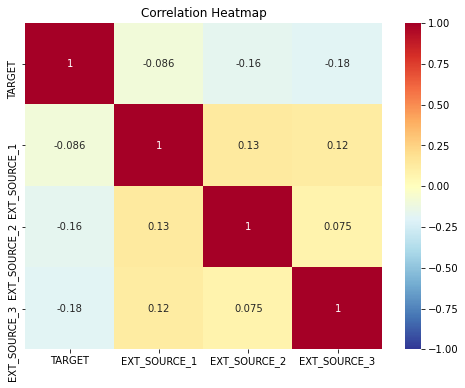

In [32]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
plt.title('Correlation Heatmap');